In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN

import sys
sys.path.append('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries/')
from clinical import load_clinical
from data_processing import *

In [2]:
adata = ad.read_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/bioclavis/00_data/2410_Bioclavis_filtered_negative_with_annotations.h5ad')
clinpath, survival, patterns = load_clinical()
core_areas = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/bioclavis/00_data/processed_core_areas.csv')
adata.obs = match_cores_to_samples(adata.obs, col_to_map='core', recipient_col='samples')

/mnt/cephfs/home/users/krakovic/.conda/envs/scpy/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries/clinical.py:7: DtypeWarning: Columns (2,10,30,37,38,52,67,84,85,110,118,134,135,136,137,138,148,149,150,217,219,221,223,224,225,226,236,242,243,244,245,248,249,250,251,252,253,254,255,256,257,261,262,263,264,265,266,267,268,269,270,271,280,282,283,285,288,289,294,295,298,299,310,311,312,313,314,315,316,317,340,374,440,441,442,443,446,447,448,449,450,451,452,453,454,455,459,460,461,462,463,464,465,466,467,468,469,481,487,508,509,510,511,512,513,514,515,538,572,638,639,640,641,644,645,646,647,648,649,650,651,652,653,657,658,659,660,661,662,663,664,665,666,667,679,685,706,707,708,709,710,711,712,713,736,770,834,835,836,839,863,887) have mixed types. Specify dtype option on import or s

In [3]:
adata.obs['core'].nunique()

2661

In [4]:
pure_cores_counts = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/bioclavis/00_data/pure_cores_densities_with_annotations.csv', index_col=0)
pure_cores_counts = pure_cores_counts.rename(columns={'cluster':'HPC'})

adata_df = adata.obs.copy(deep=True)
adata_df = adata_df[adata_df['core'].isin(pure_cores_counts['core'])].merge(pure_cores_counts[['core', 'HPC']], on='core')
adata_df

,TMA,core,compartment,CellX,CellY,leiden_0.2,leiden_0.3,leiden_0.5,cell_lineage,ki67_positive,CellX_norm,CellY_norm,tiles,samples,leiden_2.5,HPC
0,22,22-05-J,Tumour,8526.375294,-47209.294961,14,15,12,CKPAN+,0,0.173370,0.882575,1_1.jpeg,ACA_1067,46.0,HPC 46
1,22,22-05-J,Tumour,8502.780534,-47222.466136,14,7,27,CKPAN+,0,0.153310,0.870625,1_1.jpeg,ACA_1067,46.0,HPC 46
2,22,22-05-J,Tumour,8510.929662,-47224.074935,14,7,19,CKPAN+,1,0.160238,0.869166,1_1.jpeg,ACA_1067,46.0,HPC 46
3,22,22-05-J,Tumour,8517.623256,-47224.496313,14,15,8,SMA+,0,0.165929,0.868783,1_1.jpeg,ACA_1067,46.0,HPC 46
4,22,22-05-J,Stroma,8522.685445,-47229.076912,4,4,1,CKPAN+,0,0.170233,0.864628,1_1.jpeg,ACA_1067,46.0,HPC 46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833716,7,07-02-E,Stroma,16662.507831,-61368.284781,8,13,34,CKPAN+,0,0.812154,0.133889,0_0.jpeg,ACA_0411,13.0,HPC 13
3833717,7,07-02-E,Stroma,16629.507339,-61369.369176,1,22,14,CD8+,0,0.783851,0.132901,0_0.jpeg,ACA_0411,13.0,HPC 13
3833718,7,07-02-E,Stroma,16588.451347,-61369.921865,2,1,10,CD8+,0,0.748640,0.132398,0_0.jpeg,ACA_0411,13.0,HPC 13
3833719,7,07-02-E,Stroma,16574.006478,-61368.974251,13,16,18,CD4+,0,0.736252,0.133261,0_0.jpeg,ACA_0411,13.0,HPC 13


In [ ]:
leiden_clusters, malignant_clusters, stromal_clusters = load_topography()

In [6]:
adata.var_names

Index(['CKPAN_z', 'CD4_z', 'CD8_z', 'CD68_z', 'SMA_z', 'Ki67_z'], dtype='object')

### Define the DBSCAN function

In [7]:
def get_core_noise_prop(core_df, x_col, y_col, phenotype_col, phenotype, eps, min_samples):
    points = core_df[core_df[phenotype_col] == phenotype][[x_col, y_col]].values

    clusters = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=10).fit_predict(points)
    total_cells = clusters.shape[0]
    noise_cells = clusters[clusters == -1].shape[0]
    prop_noise = noise_cells / total_cells

    # Reassign labels -- merge all clusters (comparison is cohesive vs not)
    clusters[clusters != -1] = 1

    return clusters, prop_noise

# get_core_noise_prop(core_df=core_df, x_col='CellX', y_col='CellY', phenotype_col='cell_lineage', phenotype='CKPAN+', eps=15, min_samples=5)

### Visual exemplar figure

In [8]:
# import random

# fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(20,100))

# indices = np.array([random.randint(0, adata_df[adata_df['HPC'] == 'cluster_27']['core'].nunique()) for _ in range(10)])
# cores = adata_df[adata_df['HPC'] == 'cluster_27']['core'].unique()

# for i, idx in enumerate(indices):
#     core_df = adata_df.loc[(adata_df['core'] == cores[idx]) & (adata_df['cell_lineage'] == 'CKPAN+')]
#     cluster_id = core_df['HPC'].values[0]
#     clusters, noise = get_core_noise_prop(core_df=core_df, x_col='CellX', y_col='CellY', phenotype_col='cell_lineage', phenotype='CKPAN+', eps=25, min_samples=5)
#     core_df['dbscan'] = clusters
#     sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='dbscan', s=24, ax=axs[i, 0])
#     axs[i, 0].set_title(f'{cores[idx]}, {cluster_id}, {noise:.2f}')
#     sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='cell_lineage', s=24, ax=axs[i, 1])

/tmp/ipykernel_391971/4252763382.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  core_df['dbscan'] = clusters
/tmp/ipykernel_391971/4252763382.py:11: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='cell_lineage', s=24, ax=axs[0], palette=custom_colors, legend=False)
/tmp/ipykernel_391971/4252763382.py:11: UserWarning: The palette list has more values (600) than needed (5), which may not be intended.
  sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='cell_lineage', s=24, ax=axs[0], palette=custom_colors, legend=False)


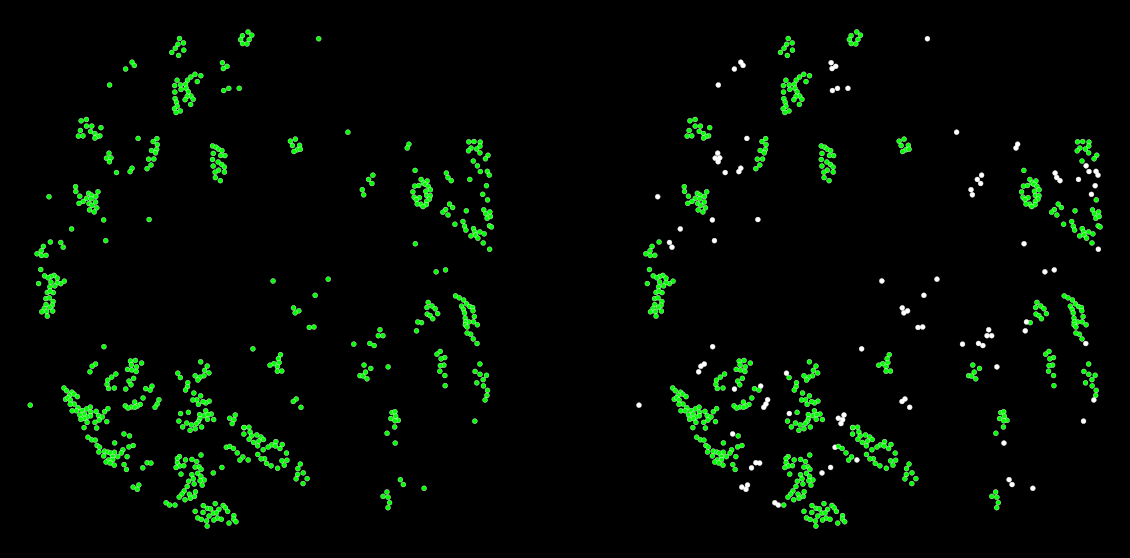

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axs = axs.flatten()

core_df = adata_df.loc[(adata_df['core'] == '23-02-C') & (adata_df['cell_lineage'] == 'CKPAN+')]

cluster_id = core_df['HPC'].values[0]
clusters, noise = get_core_noise_prop(core_df=core_df, x_col='CellX', y_col='CellY', phenotype_col='cell_lineage', phenotype='CKPAN+', eps=25, min_samples=5)
core_df['dbscan'] = clusters

custom_colors = np.where(core_df['cell_lineage'] == "CKPAN+", "lime", np.where(core_df['cell_lineage'] != "CKPAN+", "red", "red"))
sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='cell_lineage', s=24, ax=axs[0], palette=custom_colors, legend=False)

sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='dbscan', s=24, ax=axs[1], legend=False, palette={1:'lime', -1:'white'})
# axs[i, 0].set_title(f'{cores[idx]}, {cluster_id}, {noise:.2f}')

axs[0].axis('off')
axs[1].axis('off')

fig.patch.set_facecolor('black')

/tmp/ipykernel_391971/3721338981.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  core_df['dbscan'] = clusters
/tmp/ipykernel_391971/3721338981.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='cell_lineage', s=24, ax=ax, palette=custom_colors, legend=False)
/tmp/ipykernel_391971/3721338981.py:10: UserWarning: The palette list has more values (600) than needed (5), which may not be intended.
  sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='cell_lineage', s=24, ax=ax, palette=custom_colors, legend=False)


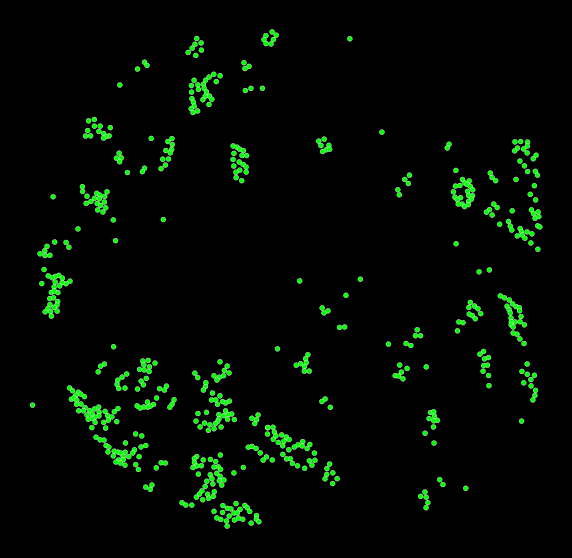

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
# axs = axs.flatten()

core_df = adata_df.loc[(adata_df['core'] == '23-02-C') & (adata_df['cell_lineage'] == 'CKPAN+')]
cluster_id = core_df['HPC'].values[0]
clusters, noise = get_core_noise_prop(core_df=core_df, x_col='CellX', y_col='CellY', phenotype_col='cell_lineage', phenotype='CKPAN+', eps=25, min_samples=5)
core_df['dbscan'] = clusters

custom_colors = np.where(core_df['cell_lineage'] == "CKPAN+", "lime", np.where(core_df['cell_lineage'] != "CKPAN+", "red", "red"))
sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='cell_lineage', s=24, ax=ax, palette=custom_colors, legend=False)

# sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='dbscan', s=24, ax=axs[1], legend=False, palette={1:'lime', -1:'white'})
# axs[i, 0].set_title(f'{cores[idx]}, {cluster_id}, {noise:.2f}')

ax.axis('off')
# axs[1].axis('off')

fig.patch.set_facecolor('black')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/bioclavis/core_23_2_C_CKPAN_scatter_black_bkg.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)

/tmp/ipykernel_391971/3320213990.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  core_df['dbscan'] = clusters


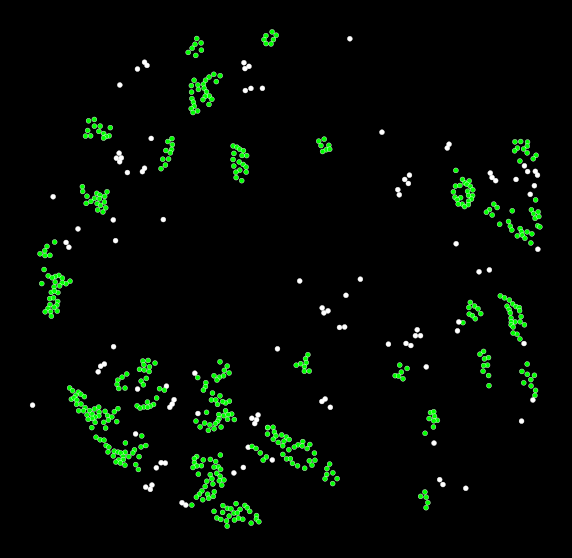

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
# axs = axs.flatten()

core_df = adata_df.loc[(adata_df['core'] == '23-02-C') & (adata_df['cell_lineage'] == 'CKPAN+')]
cluster_id = core_df['HPC'].values[0]
clusters, noise = get_core_noise_prop(core_df=core_df, x_col='CellX', y_col='CellY', phenotype_col='cell_lineage', phenotype='CKPAN+', eps=25, min_samples=5)
core_df['dbscan'] = clusters

custom_colors = np.where(core_df['cell_lineage'] == "CKPAN+", "lime", np.where(core_df['cell_lineage'] != "CKPAN+", "red", "red"))
# sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='cell_lineage', s=24, ax=ax, palette=custom_colors, legend=False)

sns.scatterplot(data=core_df, x='CellX', y='CellY', hue='dbscan', s=24, ax=ax, legend=False, palette={1:'lime', -1:'white'})
# axs[i, 0].set_title(f'{cores[idx]}, {cluster_id}, {noise:.2f}')

ax.axis('off')
# axs[1].axis('off')

fig.patch.set_facecolor('black')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/bioclavis/core_23_2_C_CKPAN_scatter_white_noise_DBSCAN_black_bkg.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)

### Analysis -- CKPAN only

In [ ]:
dbscan_noise_dict = dict()
dbscan_noise_list = list()

cores = adata_df['core'].unique()

for i, core in enumerate(cores):
    core_df = adata_df.loc[(adata_df['core'] == core) & (adata_df['cell_lineage'] == 'CKPAN+')]
    cluster_id = core_df['HPC'].values[0]
    clusters, noise = get_core_noise_prop(core_df=core_df, x_col='CellX', y_col='CellY', phenotype_col='cell_lineage', phenotype='CKPAN+', eps=25, min_samples=5)
    core_df['dbscan'] = clusters;
    try:
        dbscan_noise_dict[cluster_id].append((core, clusters, noise, core_df))
    except:
        dbscan_noise_dict[cluster_id] = list()
        dbscan_noise_dict[cluster_id].append((core, clusters, noise, core_df))
    dbscan_noise_list.append((core, cluster_id, noise))
    

In [ ]:
noise_df = pd.DataFrame(dbscan_noise_list, columns=['core', 'HPC', 'noise'])
### Filter to malignant patterns
noise_df = noise_df[noise_df['HPC'].isin([f'HPC {c}' for c in list(malignant_clusters)+[10,16]])]

### Additionally, we do not consider non-invasive patterns for this classification
noninvasive = ['HPC 35', 'HPC 41', 'HPC 46', 'HPC 54', 'HPC 52']
noise_df = noise_df[~noise_df['HPC'].isin(noninvasive)]
noise_df

,core,HPC,noise
1,22-10-B,HPC 48,0.070144
3,22-06-D,HPC 27,0.080447
4,22-04-C,HPC 64,0.118584
5,22-06-J,HPC 17,0.017598
7,22-02-F,HPC 11,0.039583
...,...,...,...
721,07-04-E,HPC 40,0.115385
722,07-04-B,HPC 10,0.349927
723,07-10-I,HPC 11,0.024876
724,07-03-C,HPC 50,0.030681


<Axes: xlabel='noise', ylabel='Density'>

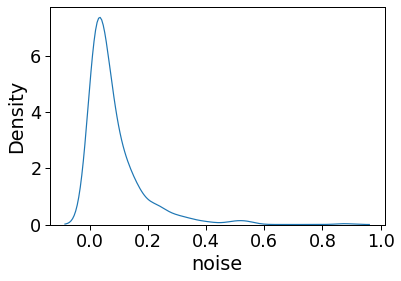

In [49]:
# Decide whether to use mean or median based on the distribution across the whole dataset
fig, ax = plt.subplots(figsize=(6,4))
sns.kdeplot(noise_df, x='noise', ax=ax)

In [ ]:
# Right skew on KDE plot above means we should use the median

medians = list()
for cluster in noise_df['HPC'].unique():
    median = np.median(noise_df[noise_df['HPC'] == cluster]['noise'].values)
    medians.append((cluster, median))

# Only n=2, omit
noise_df = noise_df[noise_df['HPC'] != 'HPC 10']
order = pd.DataFrame(medians, columns=['HPC', 'median']).sort_values(by='median')['HPC'].to_list()[::-1]

noise_df


,core,HPC,noise,robust_z_score
651,04-13-J,HPC 0,0.061876,0.224601
194,17-02-B,HPC 0,0.012086,-0.761878
634,04-09-H,HPC 0,0.008998,-0.823059
187,17-13-C,HPC 0,0.154034,2.050506
571,03-09-B,HPC 0,0.030441,-0.398210
...,...,...,...,...
237,16-14-C,HPC 69,0.069986,0.385276
609,23-09-E,HPC 69,0.067482,0.335672
533,09-03-H,HPC 69,0.091366,0.808881
674,19-04-D,HPC 69,0.029880,-0.409339


In [104]:
average_HRs = load_hazard_ratios(which='all')
average_HRs = average_HRs[average_HRs['covariate'].isin(noise_df['HPC'])]
average_HRs = average_HRs.rename(columns={'covariate':'HPC'}).set_index('HPC')
average_HRs = average_HRs.sort_index()
average_HRs

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p),se
HPC,,,,,,,,,,,
HPC 0,-4.844009e-02,0.952749,0.031415,-0.110150,0.013270,0.895883,1.013241,-1.536970,0.020767,3.036461,0.031485
HPC 11,-1.283005e-02,0.987327,0.017424,-0.056828,0.031168,0.954825,1.021724,-0.443929,0.901846,0.697720,0.022448
HPC 13,5.303606e-02,1.054499,0.034382,-0.014403,0.120475,0.985797,1.127998,1.550618,0.018144,3.095077,0.034409
HPC 16,-1.426224e-02,0.985934,0.035505,-0.092050,0.063525,0.920484,1.057328,-0.313945,0.977890,0.453253,0.039688
HPC 17,4.850562e-03,1.004875,0.017242,-0.038758,0.048459,0.971749,1.039918,0.170512,0.998723,0.225571,0.022250
HPC 21,1.202522e-02,1.012170,0.018818,-0.035565,0.059616,0.975668,1.050985,0.382028,0.945836,0.581871,0.024281
HPC 27,1.053409e-01,1.111162,0.041357,0.024177,0.186505,1.024681,1.204962,2.560712,0.000001,6.656536,0.041411
HPC 28,-1.878733e-08,1.000000,0.000054,-0.000107,0.000107,0.999895,1.000105,-0.000309,1.000000,0.000450,0.000054
HPC 30,4.132118e-02,1.042213,0.030016,-0.017564,0.100207,0.982680,1.105360,1.384061,0.050568,2.635884,0.030044


In [105]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, TwoSlopeNorm

vmin, vmax = average_HRs['exp(coef)'].min(), average_HRs['exp(coef)'].max()

norm = TwoSlopeNorm(vmin=0.95, vmax=1.05, vcenter=1)
cmap = plt.cm.coolwarm
sm = ScalarMappable(norm=norm, cmap=cmap)

row_colors = pd.DataFrame(sm.to_rgba(average_HRs['exp(coef)']), index=average_HRs.index, columns=['R', 'G', 'B', 'A'])
row_colors = row_colors.apply(lambda x: tuple(x), axis=1)
row_colors.name = 'Hazard \nRatio'

In [106]:
noise_df['hpc_num'] = noise_df['HPC'].apply(lambda x: int(x.split(" ")[1]))
noise_df = noise_df[noise_df['hpc_num'].isin(list(malignant_clusters)+[10,16])]
noise_df = noise_df.drop(labels=['hpc_num'], axis=1)
noise_df = noise_df.sort_values('HPC')
noise_df

,core,HPC,noise,robust_z_score
651,04-13-J,HPC 0,0.061876,0.224601
156,05-12-I,HPC 0,0.030247,-0.402069
487,06-03-A,HPC 0,0.027876,-0.449039
149,05-05-D,HPC 0,0.111111,1.200080
658,04-12-D,HPC 0,0.128655,1.547673
...,...,...,...,...
442,08-07-C,HPC 69,0.051571,0.020432
421,10-04-E,HPC 69,0.075862,0.501699
674,19-04-D,HPC 69,0.029880,-0.409339
485,06-02-F,HPC 69,0.057578,0.139448


/tmp/ipykernel_391971/2198705201.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=noise_df, x='HPC', y='noise', order=order, ax=ax, palette=dict(row_colors), estimator='median', errorbar='ci')


/tmp/ipykernel_391971/2198705201.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


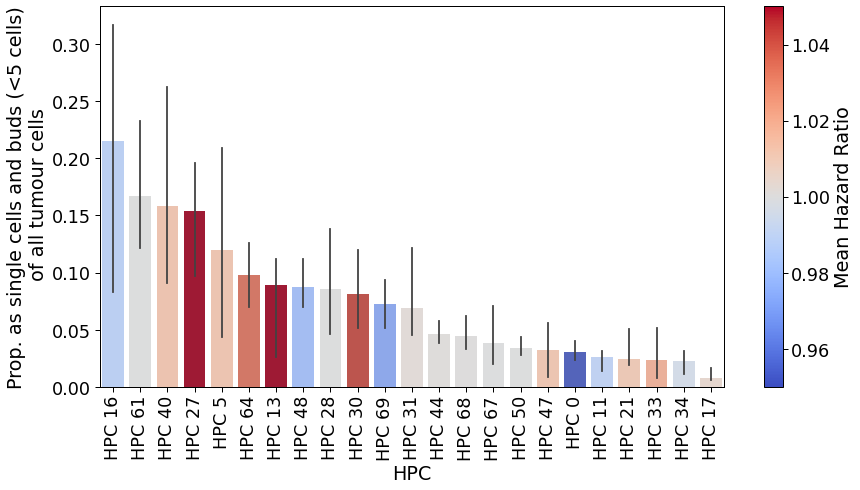

In [107]:
sns.set_context("paper", font_scale=2.0)
fig, ax = plt.subplots(figsize=(14,7))

sns.barplot(data=noise_df, x='HPC', y='noise', order=order, ax=ax, palette=dict(row_colors), estimator='median', errorbar='ci')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Prop. as single cells and buds (<5 cells)\n of all tumour cells')
cbar = fig.colorbar(sm, orientation='vertical', ax=ax, aspect=20)
cbar.set_label('Mean Hazard Ratio')
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/bioclavis/barplot_prop_cohesion_color_all_hazard_ratio.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)

/tmp/ipykernel_391971/954915173.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Prop. as single cells and buds (<5 cells)\n of all tumour cells')

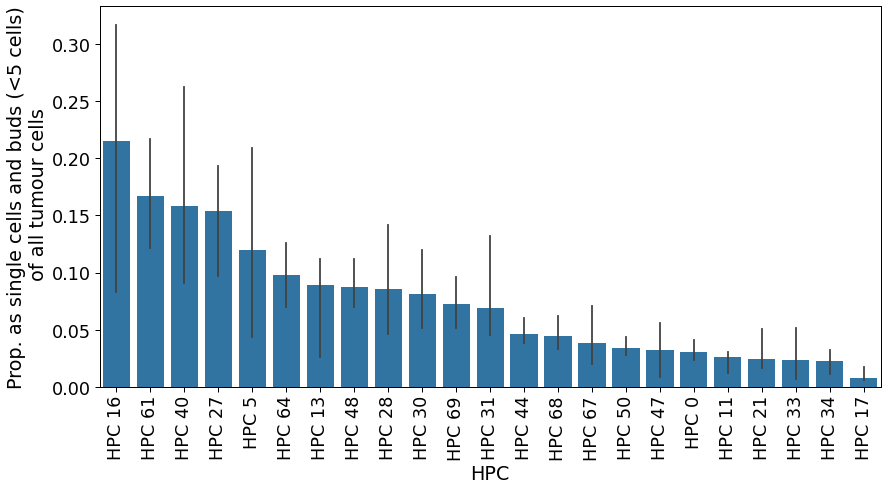

In [108]:
sns.set_context("paper", font_scale=2.0)
fig, ax = plt.subplots(figsize=(14,7))

sns.barplot(data=noise_df, x='HPC', y='noise', order=order, ax=ax, estimator='median', errorbar='ci')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Prop. as single cells and buds (<5 cells)\n of all tumour cells')
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/bioclavis/barplot_prop_cohesion_color_None.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [109]:
noise_df.groupby('HPC').agg('median')['noise'].to_frame()

/tmp/ipykernel_391971/2050523863.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  noise_df.groupby('HPC').agg('median')['noise'].to_frame()


,noise
HPC,
HPC 0,0.030344
HPC 11,0.025816
HPC 13,0.088962
HPC 16,0.215348
HPC 17,0.008196
HPC 21,0.024876
HPC 27,0.154209
HPC 28,0.085580
HPC 30,0.080967


In [110]:
from scipy.stats import median_abs_deviation

noise_mean = noise_df['noise'].mean()
noise_med = noise_df['noise'].median()
noise_std = noise_df['noise'].std()
noise_mad = median_abs_deviation(noise_df['noise'], scale='normal')

def z_score(x, x_mean, x_std):
    return (x - x_mean) / x_std

def robust_z_score(x, x_median, x_mad):
    return (x - x_median) / x_mad

noise_df['robust_z_score'] = noise_df['noise'].apply(lambda x: robust_z_score(x, noise_med, noise_mad))
z_mean_noise = noise_df.groupby('HPC').agg('mean').reset_index().sort_values(by='robust_z_score', ascending=False)
z_noise_order = list(z_mean_noise['HPC'])

/tmp/ipykernel_391971/3026363928.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  z_mean_noise = noise_df.groupby('HPC').agg('mean').reset_index().sort_values(by='robust_z_score', ascending=False)


In [111]:
median_noise = noise_df.groupby('HPC').agg('median').reset_index().sort_values(by='noise')
median_noise['median'] = median_noise['noise'].apply(lambda x: 1 if x > np.median(noise_df['noise']) else 0)

median_noise

/tmp/ipykernel_391971/3237796535.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_noise = noise_df.groupby('HPC').agg('median').reset_index().sort_values(by='noise')


,HPC,noise,robust_z_score,median
4,HPC 17,0.008196,-0.842181,0
11,HPC 34,0.022524,-0.555179,0
10,HPC 33,0.023779,-0.530041,0
5,HPC 21,0.024876,-0.508074,0
1,HPC 11,0.025816,-0.489230,0
0,HPC 0,0.030344,-0.398536,0
14,HPC 47,0.032451,-0.356320,0
17,HPC 50,0.034052,-0.324268,0
20,HPC 67,0.038411,-0.236941,0
21,HPC 68,0.044327,-0.118437,0


/tmp/ipykernel_391971/2879100613.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=noise_df, x='HPC', y='robust_z_score', order=z_noise_order, ax=ax, palette=dict(row_colors))
/tmp/ipykernel_391971/2879100613.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


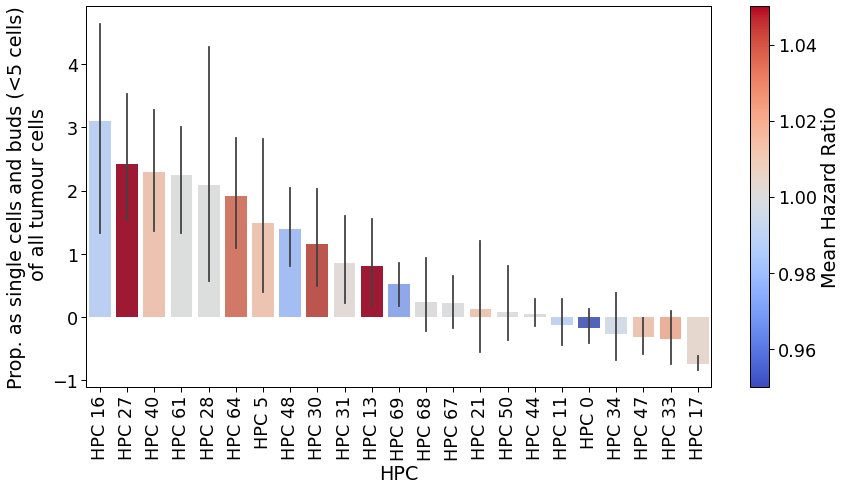

In [112]:
sns.set_context("paper", font_scale=2.0)
fig, ax = plt.subplots(figsize=(14,7))

sns.barplot(data=noise_df, x='HPC', y='robust_z_score', order=z_noise_order, ax=ax, palette=dict(row_colors))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Prop. as single cells and buds (<5 cells)\n of all tumour cells')
cbar = fig.colorbar(sm, orientation='vertical', ax=ax, aspect=20)
cbar.set_label('Mean Hazard Ratio')
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/bioclavis/barplot_z_score_cohesion_color_all_hazard_ratio.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)

/tmp/ipykernel_391971/1353152389.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


Text(0.5, 0, 'Discohesion Z-score')

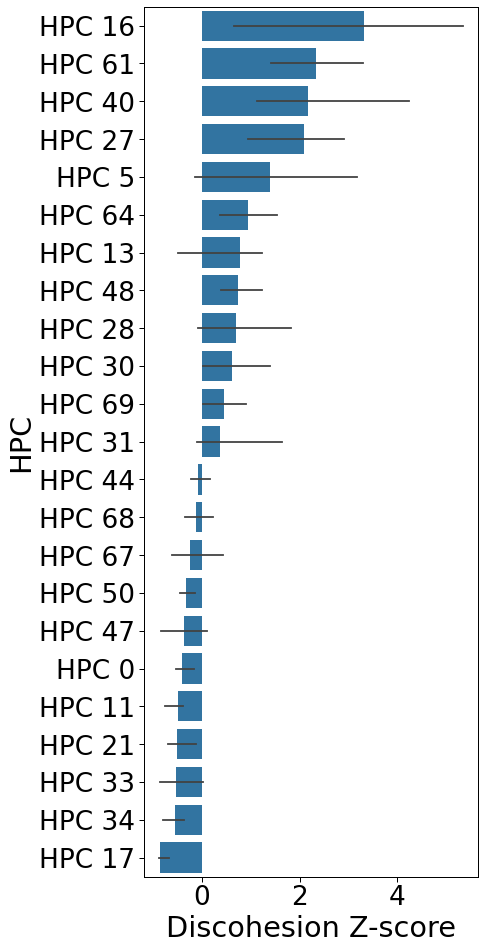

In [ ]:
sns.set_context("paper", font_scale=3.0)
fig, ax = plt.subplots(figsize=(6,16))

cluster_annotations = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/bioclavis/pure_by_supercluster_bioclavis_all.csv', index_col=0)
cluster_annotations = cluster_annotations.drop(labels='core_ID', axis=1).dropna().drop_duplicates().sort_values(by='cluster').set_index('cluster')
cluster_annotations = cluster_annotations.replace({'hot_cohesive':'Hot cohesive',
                                                   'cold_cohesive':'Cold cohesive',
                                                   'cold_discohesive':'Cold discohesive',
                                                   'hot_discohesive':'Hot discohesive'})
cluster_annotations = cluster_annotations.rename(columns={'supercluster':'Supercluster'})

sns.barplot(data=noise_df[noise_df['HPC'].isin(cluster_annotations.index)], y='HPC', x='robust_z_score', estimator='median', order=median_noise['HPC'][::-1], errorbar='ci', ax=ax, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel('Discohesion Z-score')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/bioclavis/250328_barplot_robust_z_score_cohesion_color_all_hazard_ratio_horizontal_filtered_HPCs.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

/tmp/ipykernel_391971/1840001636.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Discohesion Z-score')

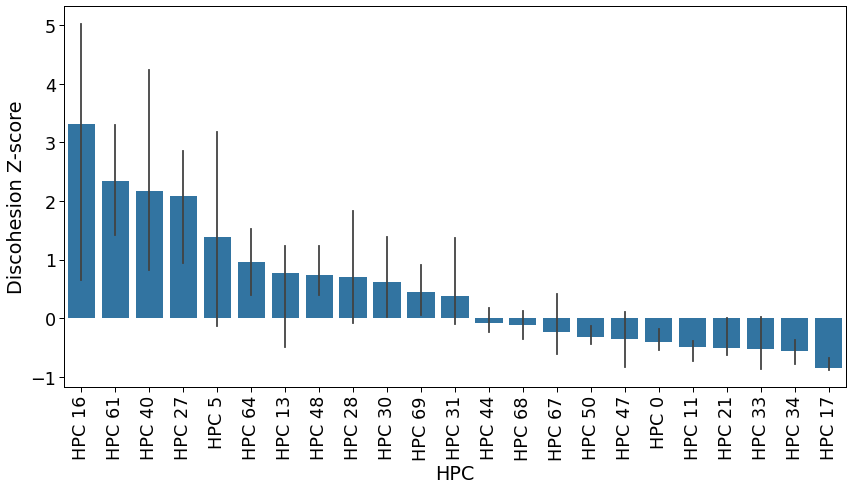

In [122]:
sns.set_context("paper", font_scale=2.0)
fig, ax = plt.subplots(figsize=(14,7))

sns.barplot(data=noise_df[noise_df['HPC'].isin(cluster_annotations.index)], x='HPC', y='robust_z_score', estimator='median', order=median_noise['HPC'][::-1], errorbar='ci', ax=ax)
# sns.barplot(data=noise_df, x='HPC', y='robust_z_score', order=z_noise_order, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Discohesion Z-score')
# plt.tight_layout()
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/bioclavis/barplot_z_score_cohesion_color_None.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [126]:
noise_df.to_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/bioclavis/data/noise_df_per_core.csv')

In [127]:
median_noise.to_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/bioclavis/data/median_noise_per_cluster.csv')